In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from implied_vol import *
from finite_diff_methods import *

In [44]:
call = pd.read_pickle("./datasets/call.pkl")
put = pd.read_pickle("./datasets/put.pkl")
equity_data = pd.read_pickle("./datasets/equity.pkl")

In [45]:
# clean
expiry = ['2021-04-16', '2021-05-21', '2021-06-18']
def clean(data):
    new_data = []
    for df,date in zip(data, expiry):
        df['expiry'] = pd.to_datetime(date)
        df['t2m'] = (df['expiry'] - pd.Timestamp('today')) / np.timedelta64(1, 'Y')
        df['s0'] = equity_data.iloc[0,3]
        df['market_price'] = df.bid/2 + df.ask/2
        # choose strike between 385 to 395
        new_df = df.loc[df.strike.isin(np.arange(385,395))].reset_index()
        del new_df['index']
        new_data.append(new_df)
    return new_data
call = clean(call)
put = clean(put)

In [46]:
# get vol
r = 0.07/100
for df in call:
    df['type'] = 'c'
    df['vol'] = df.apply(lambda x:
                         get_impliedVol('c', x.s0, x.strike, x.t2m, r, x.market_price),axis=1)

for df in put:
    df['type'] = 'p'
    df['vol'] = df.apply(lambda x:
                         get_impliedVol('p', x.s0, x.strike, x.t2m, r, x.market_price),axis=1)

In [47]:
epsilon = 0.001

In [48]:
def fd_price(x, epsilon, method):
    dt = epsilon / (3 * x.vol ** 2 + 1)
    dx = x.vol * np.sqrt(3 * dt)
    N = int(np.ceil(x.t2m / dt))
    Nj = int(np.ceil((2 * np.sqrt(3 * N) - 1) / 2))
    return method(x.s0, x.strike, x.t2m, r, x.vol, 0, N, Nj, dx, x.type, 'e')

In [49]:
for df1,df2 in zip(call, put):
    df1['EFD'] = df1.apply(lambda x: 
                           fd_price(x, epsilon, e_fdm),axis=1)
    df1['IFD'] = df1.apply(lambda x:
                           fd_price(x, epsilon, i_fdm),axis=1)
    df1['CNFD'] = df1.apply(lambda x:
                            fd_price(x, epsilon, cn_fdm),axis=1)
    df2['EFD'] = df2.apply(lambda x:
                           fd_price(x, epsilon, e_fdm),axis=1)
    df2['IFD'] = df2.apply(lambda x:
                           fd_price(x, epsilon, i_fdm),axis=1)
    df2['CNFD'] = df2.apply(lambda x:
                            fd_price(x, epsilon, cn_fdm),axis=1)

In [50]:
def get_greeks(x):
    dt = epsilon / (3 * x.vol ** 2 + 1)
    dx = x.vol * np.sqrt(3 * dt)
    N = int(np.ceil(x.t2m / dt))
    Nj = int(np.ceil((2 * np.sqrt(3 * N) - 1) / 2))
    delta,gamma,theta = delta_gamma_theta(x.s0, x.strike, x.t2m, r, x.vol, 0, N, Nj, dx, x.type)
    vega_ = vega(x.s0, x.strike, x.t2m, r, x.vol, 0, N, Nj, dx, x.type)
    return delta, gamma, vega_, theta

In [51]:
for df1,df2 in zip(call, put):
    df1[['delta', 'gamma', 'vega', 'theta']] = \
    df1.apply(get_greeks,axis=1, result_type="expand")
    df2[['delta', 'gamma', 'vega', 'theta']] = \
    df2.apply(get_greeks,axis=1, result_type="expand")

In [52]:
# save to csv
for df1,df2 in zip(call, put):
    path1 = './p2_csv/' + df1.iloc[0,0][0:10] + '.csv'
    path2 = './p2_csv/' + df2.iloc[0,0][0:10] + '.csv'
    df1.to_csv(path1, index=False)
    df2.to_csv(path2, index=False)

In [58]:
info = ['t2m', 'strike', 'type', 'ask', 'bid',
       'market_price', 'vol', 'EFD', 'IFD', 'CNFD']
data1 = call[1][info].round(4)
data2 = put[1][info].round(4)
data1 = data1.sort_values(by='market_price', ascending=False)
data2 = data2.sort_values(by='market_price', ascending=False)
data1.to_csv('./p2_csv/d_res1.csv', index=False)
data2.to_csv('./p2_csv/d_res2.csv', index=False)

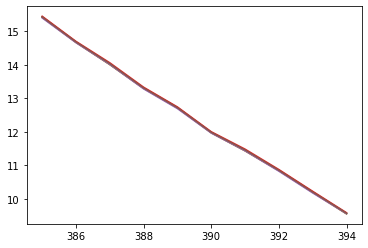

In [59]:
plt.plot(data1.strike, data1.EFD)
plt.plot(data1.strike, data1.IFD)
plt.plot(data1.strike, data1.CNFD)
plt.plot(data1.strike, data1.ask)
plt.plot(data1.strike, data1.bid)
plt.plot(data1.strike, data1.market_price)

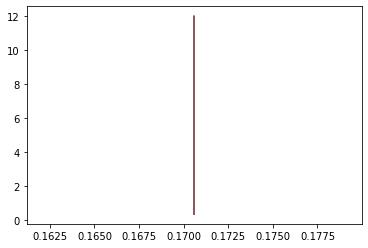

In [56]:
info = ['strike','market_price', 'vol', 
       'delta', 'gamma', 'theta', 'vega']
data3 = call[0][info].round(4)
data4 = put[0][info].round(4)
data3 = data3.sort_values(by='market_price', ascending=False)
data4 = data4.sort_values(by='market_price', ascending=False)
data3.to_csv('./p2_csv/greek_call0416.csv', index=False)
data4.to_csv('./p2_csv/greek_put0416.csv', index=False)